# Plasma centrifuge model

From [_Wijnakker, M. M. B., & Amsterdam Univ. (Netherlands). (1980). Centrifugal effects in a weakly ionized rotating gas_](https://inis.iaea.org/records/ymfdn-qv182)

$$
\sigma_\perp \frac{1}{r} \frac{\partial}{\partial r} \left( r \frac{\partial \Phi}{\partial r} \right) + \sigma \frac{\partial^2 \Phi}{\partial z^2} - \sigma_\perp B_0 \frac{1}{r} \frac{\partial}{\partial r}(r v_\theta) = 0
$$

$$
\mu \left(\frac{\partial}{\partial r} (\frac{1}{r} \frac{\partial}{\partial r} (r v_\theta)) + \frac{\partial^2 v_\theta}{\partial z^2}\right) - \sigma_\perp B_0 \left(-\frac{\partial \Phi}{\partial r} + v_\theta B_0 =0 \right)
$$

In [1]:
import dolfinx
from mpi4py import MPI
from dolfinx.fem.petsc import NonlinearProblem
from dolfinx.nls.petsc import NewtonSolver
from dolfinx.fem import (
    functionspace,
    Function,
    locate_dofs_topological,
    dirichletbc,
)
from dolfinx import log
from ufl import TestFunctions, grad, dot, inner
import ufl
from basix.ufl import element
from dolfinx.mesh import locate_entities_boundary, meshtags

import numpy as np

# log.set_log_level(log.LogLevel.INFO)

Let's start by defining the variables we'll need for the problem.

In [2]:
R_0 = 6e-2
R1 = R_0 * 0.07
c = 4 * R_0
c_0 = c * 0.66
I = 100  # total current
B0 = 0.13  # magnetic field
viscosity = 6.8e-5  # viscosity Pa s
sigma = 700  # conductivity Ohm-1 m-1
beta_eff = 8
voltage = 58.0  # V

In [3]:
def sigma_perp_fun(sigma, beta_e):
    """Eq 6 from Winjakker Thesis"""
    return sigma * 1 / (1 + beta_e**2)


def sigma_H_fun(sigma, beta_e):
    """Eq 6 from Winjakker Thesis"""
    return sigma * beta_e / (1 + beta_e**2)


def hartmann_number(B0, R_0, sigma, mu):
    """Eq 1 from Winjakker Thesis"""
    return B0 * R_0 * np.sqrt(sigma / mu)


sigma_perp = sigma_perp_fun(sigma, beta_eff)

print(f"Hartmann number: {hartmann_number(B0, R_0, sigma, viscosity):.2f}")
print(f"beta_eff: {beta_eff:.2f}")
print(f"sigma: {sigma:.2f}")
print(f"sigma_perp: {sigma_perp:.2f}")

Hartmann number: 25.03
beta_eff: 8.00
sigma: 700.00
sigma_perp: 10.77


We now create a mesh, a functionspace and a `Function` (containing two subfunctions) for potential $\Phi$ and azimuthal velocity $v_\theta$. We also create test functions for the variational problem.

In [4]:
mesh = dolfinx.mesh.create_rectangle(
    MPI.COMM_WORLD, [np.array([0.0, 0.0]), np.array([c, R_0])], [150, 200]
)

V = functionspace(mesh, element("Lagrange", mesh.topology.cell_name(), 1, shape=(2,)))

u = Function(V)
phi, v_theta = ufl.split(u)
phi_v, v_theta_test = TestFunctions(V)

We need to create some facet meshtags to be able to apply the boundary conditions later.

In [5]:
tdim = mesh.topology.dim
facets_top = locate_entities_boundary(mesh, tdim - 1, lambda x: np.isclose(x[1], R_0))
facets_left = locate_entities_boundary(mesh, tdim - 1, lambda x: np.isclose(x[0], 0))
facets_bot = locate_entities_boundary(mesh, tdim - 1, lambda x: np.isclose(x[1], 0))
facets_near_cathode = locate_entities_boundary(
    mesh,
    tdim - 1,
    lambda x: np.logical_and(np.isclose(x[1], R1, rtol=0.1), np.isclose(x[0], 0)),
)

dofs_near_cathode = locate_dofs_topological(V.sub(0), tdim - 1, facets_near_cathode)
dofs_left = locate_dofs_topological(V.sub(1), tdim - 1, facets_left)
dofs_top = locate_dofs_topological(V.sub(1), tdim - 1, facets_top)
dofs_bot = locate_dofs_topological(V.sub(1), tdim - 1, facets_bot)

# create facet markers
facet_indices, facet_markers = [], []
for marker, facets in zip([1, 2], [facets_top, facets_left]):
    for facet in facets:
        facet_indices.append(facet)
        facet_markers.append(marker)

facet_indices = np.hstack(facet_indices).astype(np.int32)
facet_markers = np.hstack(facet_markers).astype(np.int32)
sorted_facets = np.argsort(facet_indices)
fdim = mesh.topology.dim - 1

facet_tag = meshtags(
    mesh, fdim, facet_indices[sorted_facets], facet_markers[sorted_facets]
)

The current flux (Neumann) boundary conditions are imposed using a delta function:

In [6]:
def delta_function(x, a, mod=np):
    return mod.exp(-((x / a) ** 2)) / (a * mod.sqrt(mod.pi))


a_param = 1 / 300


def flux_left(r, mod=np):
    return -I * delta_function(r - R1, a=a_param, mod=mod) / (2 * mod.pi * R_0)


def flux_top(z, mod=np):
    return +I * delta_function(z - c_0, a=a_param, mod=mod) / (2 * mod.pi * R_0)

This is what the flux distributions look like.

> Note:
> Depending on the refinement of the mesh, these delta functions may not look so smooth

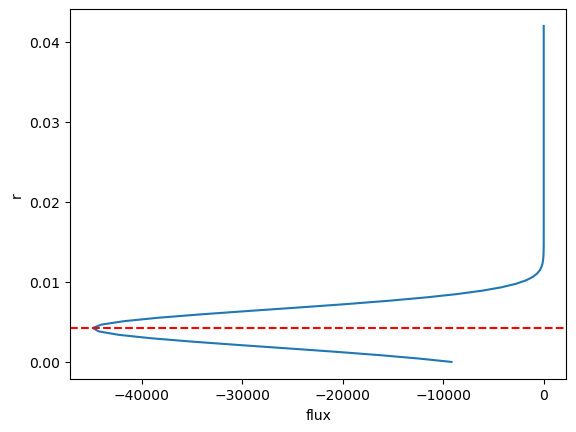

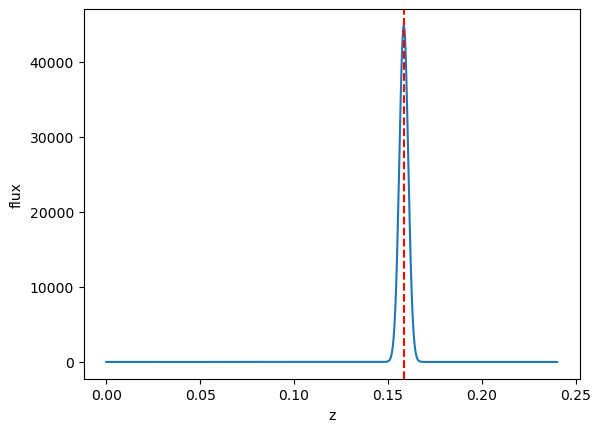

In [7]:
import matplotlib.pyplot as plt

r_values = np.linspace(0, R1 * 10, 100)
z_values = np.linspace(0, c, 500)

plt.plot(flux_left(r_values), r_values, label="flux_left")
plt.axhline(R1, color="red", linestyle="--")
plt.ylabel("r")
plt.xlabel("flux")
plt.show()

plt.plot(z_values, flux_top(z_values), label="flux_top")
plt.axvline(c_0, color="red", linestyle="--")
plt.ylabel("flux")
plt.xlabel("z")
plt.show()

Now we can write the variational formulation

In [8]:
# variational formulation
ds = ufl.Measure("ds", domain=mesh, subdomain_data=facet_tag)
dx = ufl.Measure("dx", domain=mesh)

F = 0
x = ufl.SpatialCoordinate(mesh)
z, r = x[0], x[1]

# potential
sigma_tensor = ufl.as_tensor([[sigma, 0], [0, sigma_perp]])

F += inner(sigma_tensor * grad(phi), grad(phi_v)) * r * dx
F += -sigma_perp * B0 / r * (r * v_theta).dx(1) * phi_v * r * dx

# add fluxes
F += -flux_left(r=r, mod=ufl) * phi_v * r * ds(2)
F += -flux_top(z=z, mod=ufl) * phi_v * r * ds(1)


# velocity
F += viscosity * dot(grad(v_theta), grad(v_theta_test)) * r * dx
F += sigma_perp * B0 * (-phi.dx(1) + v_theta * B0) * v_theta_test * r * dx

We create 3 non-slip boundary conditions applied to the left, top, and bottom boundaries.

We also constrain the cathode to be at the right voltage.

In [9]:
# we constrain the annode to around -50 because the problem is ill-posed
assert len(dofs_near_cathode) > 0, "No dofs found near cathode"
constrain_cathode = dirichletbc(
    dolfinx.fem.Constant(mesh, -voltage), dofs_near_cathode, V.sub(0)
)
non_slip_left = dirichletbc(dolfinx.fem.Constant(mesh, 0.0), dofs_left, V.sub(1))
non_slip_top = dirichletbc(dolfinx.fem.Constant(mesh, 0.0), dofs_top, V.sub(1))
non_slip_bot = dirichletbc(dolfinx.fem.Constant(mesh, 0.0), dofs_bot, V.sub(1))

bcs = [
    non_slip_left,
    non_slip_top,
    non_slip_bot,
    constrain_cathode,
]

We can now create a nonlinear problem and solve it

In [10]:
problem = NonlinearProblem(F, u, bcs=bcs)
solver = NewtonSolver(MPI.COMM_WORLD, problem)

n, converged = solver.solve(u)

To use the potential and velocity fields in the post-processing, we split the `u` function:

In [11]:
potential, velocity = u.split()

# collapse needed
potential = potential.collapse()
velocity = velocity.collapse()

## Pressure profile

The pressure $P$ on a radial profile can be computed by solving:

$$
\frac{dP}{dr} = p \frac{m}{kT} \frac{v_\theta^2}{r} - \sigma_H B_0 \left( - \frac{\partial \Phi}{\partial r} + v_\theta B_0 \right)
$$

First, we create a 1D submesh on a radial profile.

In [12]:
pressure_profile_loc = c
entities = dolfinx.mesh.locate_entities(
    mesh, mesh.topology.dim - 1, lambda x: np.isclose(x[0], pressure_profile_loc)
)

mesh_1d, entity_map, vmap, _ = dolfinx.mesh.create_submesh(
    mesh, dim=1, entities=entities
)

Create a new functionspace, function for pressure, and test function

In [13]:
V_p = functionspace(mesh_1d, ("CG", 1))
p = dolfinx.fem.Function(V_p)
p_v = ufl.TestFunction(V_p)

Because codim 1 problems are not yet supported, we need to interpolate the 2D velocity and potential onto suitable 1D functions:

In [14]:
def nmm_interpolate(f_out: dolfinx.fem.Function, f_in: dolfinx.fem.Function):
    """Non Matching Mesh Interpolate: interpolate one function (f_in) from one mesh into
    another function (f_out) with a mismatching mesh

    args:
        f_out: function to interpolate into
        f_in: function to interpolate from

    notes:
    https://fenicsproject.discourse.group/t/gjk-error-in-interpolation-between-non-matching-second-ordered-3d-meshes/16086/6
    """

    dim = f_out.function_space.mesh.topology.dim
    index_map = f_out.function_space.mesh.topology.index_map(dim)
    ncells = index_map.size_local + index_map.num_ghosts
    cells = np.arange(ncells, dtype=np.int32)
    interpolation_data = dolfinx.fem.create_interpolation_data(
        f_out.function_space, f_in.function_space, cells, padding=1e-11
    )
    f_out.interpolate_nonmatching(f_in, cells, interpolation_data=interpolation_data)


velocity_1d = dolfinx.fem.Function(V_p)
potential_1d = dolfinx.fem.Function(V_p)
nmm_interpolate(velocity_1d, velocity)
nmm_interpolate(potential_1d, potential)

Set up the 1D variational problem, constrain the pressure to 1 Torr at $r=R_0$ and solve

In [15]:
tdim = mesh_1d.topology.dim
facets_top = locate_entities_boundary(
    mesh_1d, tdim - 1, lambda x: np.isclose(x[1], R_0)
)
dofs_top = locate_dofs_topological(V_p, tdim - 1, facets_top)

sigma_H = dolfinx.fem.Constant(mesh_1d, sigma_H_fun(sigma, beta_eff))

m = 6.67e-27  # kg
T = 2500.0  # K
k = 1.380649e-23  # J/K

dx_1d = ufl.Measure("dx", domain=mesh_1d)
r_1d = ufl.SpatialCoordinate(mesh_1d)[1]

F_pressure = 0
F_pressure += p.dx(1) * p_v * dx_1d
F_pressure += -m / (k * T) * velocity_1d**2 / r_1d * p * p_v * dx_1d
F_pressure += +sigma_H * B0 * (-potential_1d.dx(1) + velocity_1d * B0) * p_v * dx_1d

p0 = 133.3  # Pa
bcs_pressure = [
    dolfinx.fem.dirichletbc(dolfinx.fem.Constant(mesh_1d, p0), dofs_top, V_p),
]

problem = NonlinearProblem(F_pressure, p, bcs=bcs_pressure)
solver = NewtonSolver(MPI.COMM_WORLD, problem)

log.set_log_level(log.LogLevel.INFO)
n, converged = solver.solve(p)

[2025-04-07 14:25:00.865] [info] Newton iteration 0: r (abs) = 149.03936364353794 (tol = 1e-10), r (rel) = inf (tol = 1e-09)
[2025-04-07 14:25:00.866] [info] PETSc Krylov solver starting to solve system.
[2025-04-07 14:25:00.866] [info] Newton iteration 1: r (abs) = 2.270483606891345e-07 (tol = 1e-10), r (rel) = 1.3636048888536212e-10 (tol = 1e-09)
[2025-04-07 14:25:00.866] [info] Newton solver finished in 1 iterations and 1 linear solver iterations.


## Post processing

We can write the potential and the velocity fields to VTX

In [16]:
from dolfinx.io import VTXWriter


writer = VTXWriter(MPI.COMM_WORLD, "potential.bp", [potential], "BP5")
writer.write(0.0)


writer = VTXWriter(MPI.COMM_WORLD, "velocity.bp", [velocity], "BP5")
writer.write(0.0)

It is also possible to calculate the current integral and verify that it matches the set current:

In [17]:
# integrate current density

current_left = dolfinx.fem.assemble_scalar(
    dolfinx.fem.form(-sigma * potential.dx(0) * 2 * ufl.pi * r * ds(2))
)
current_top = dolfinx.fem.assemble_scalar(
    dolfinx.fem.form(sigma_perp * potential.dx(1) * 2 * ufl.pi * r * ds(1))
)

print(f"Expected current: {I}")
print(f"Current left: {current_left:.2f}")
print(f"Current top: {current_top:.2f}")

[2025-04-07 14:25:00.899] [info] Requesting connectivity (1, 0) - (2, 0)
[2025-04-07 14:25:00.899] [info] Requesting connectivity (2, 0) - (1, 0)
[2025-04-07 14:25:00.899] [info] Requesting connectivity (1, 0) - (2, 0)
[2025-04-07 14:25:00.900] [info] Requesting connectivity (2, 0) - (1, 0)
Expected current: 100
Current left: -96.46
Current top: 99.64
[2025-04-07 14:25:00.903] [info] Requesting connectivity (1, 0) - (2, 0)
[2025-04-07 14:25:00.903] [info] Requesting connectivity (2, 0) - (1, 0)
[2025-04-07 14:25:00.903] [info] Requesting connectivity (1, 0) - (2, 0)
[2025-04-07 14:25:00.903] [info] Requesting connectivity (2, 0) - (1, 0)


We can visualise the fields with `pyvista`

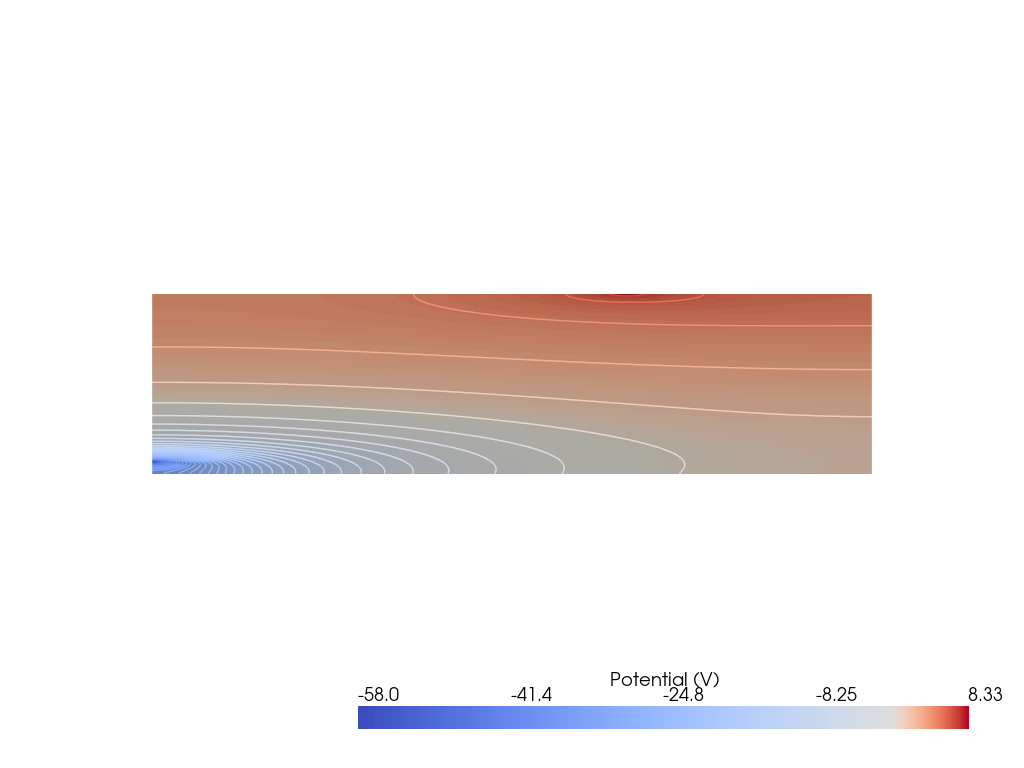

In [18]:
import pyvista
from dolfinx.plot import vtk_mesh
from matplotlib.colors import TwoSlopeNorm, ListedColormap

u_topology, u_cell_types, u_geometry = vtk_mesh(V)

u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)
u_grid.point_data["potential"] = potential.x.array.real
u_grid.set_active_scalars("potential")

# Calculate the data range
data_min = np.min(u_grid.point_data["potential"])
data_max = np.max(u_grid.point_data["potential"])

# Create a TwoSlopeNorm centered at zero
norm = TwoSlopeNorm(vmin=data_min, vcenter=0, vmax=data_max)
mapping = np.linspace(data_min, data_max, 256)
newcolors = plt.cm.coolwarm(norm(mapping))
new_cmap = ListedColormap(newcolors)

u_plotter = pyvista.Plotter()

u_plotter.add_mesh(
    u_grid, show_edges=False, cmap=new_cmap, scalar_bar_args={"title": "Potential (V)"}
)
contours = u_grid.contour(50)
u_plotter.add_mesh(contours, cmap=new_cmap, scalar_bar_args={"title": "Potential (V)"})
u_plotter.view_xy()
if not pyvista.OFF_SCREEN:
    u_plotter.show()

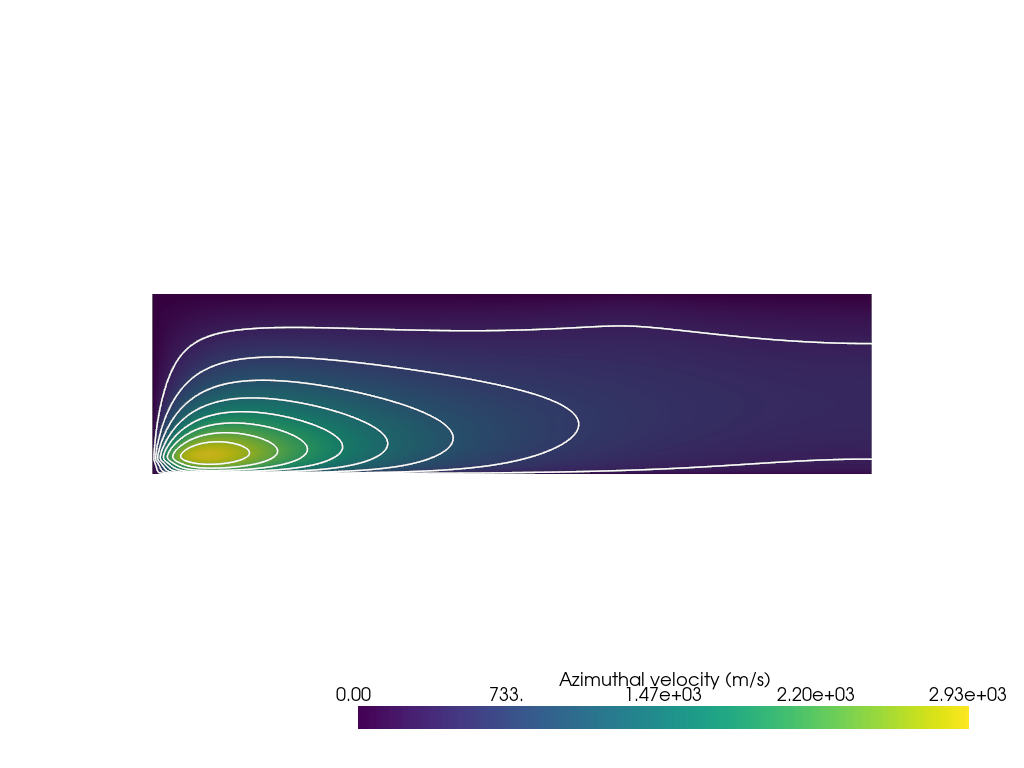

In [19]:
u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)
u_grid.point_data["azimuthal_velocity"] = velocity.x.array.real
u_grid.set_active_scalars("azimuthal_velocity")
u_plotter = pyvista.Plotter()
u_plotter.add_mesh(
    u_grid, show_edges=False, scalar_bar_args={"title": "Azimuthal velocity (m/s)"}
)

contours = u_grid.contour()
u_plotter.add_mesh(contours, opacity=1, color="white", line_width=0.5)
u_plotter.view_xy()
if not pyvista.OFF_SCREEN:
    u_plotter.show()

Now we can plot the velocity, potential, and pressure radial profiles:

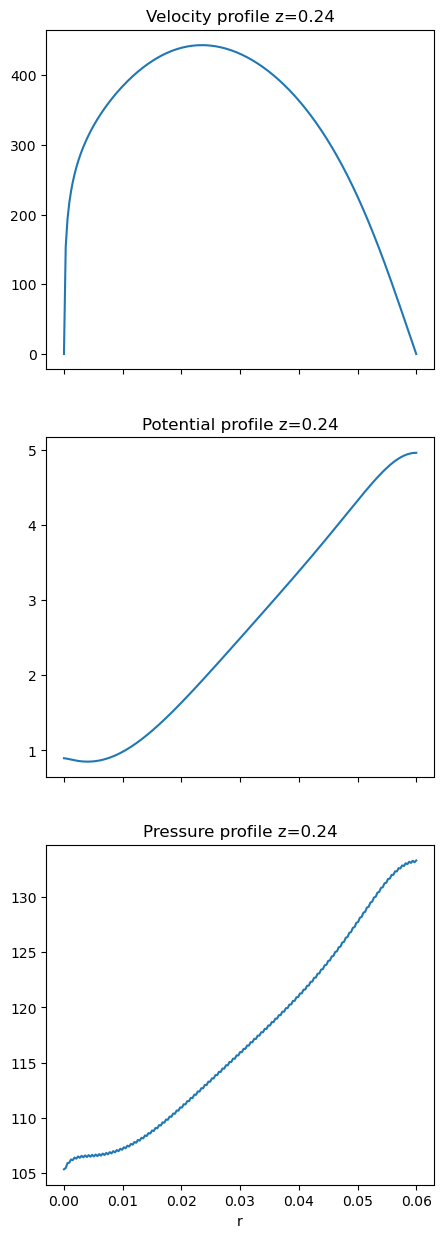

In [20]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1, figsize=(5, 15), sharex=True)
axs[0].plot(mesh_1d.geometry.x[:, 1], velocity_1d.x.array)
axs[0].set_title(f"Velocity profile z={pressure_profile_loc}")
axs[1].plot(mesh_1d.geometry.x[:, 1], potential_1d.x.array)
axs[1].set_title(f"Potential profile z={pressure_profile_loc}")
axs[2].set_title(f"Pressure profile z={pressure_profile_loc}")
axs[2].plot(mesh_1d.geometry.x[:, 1], p.x.array)
axs[2].set_xlabel("r")
plt.show()